Theoretical best max vertex label (K): 14
Theoretical best max edge weight: 28

Found solution: max vertex label=15, max edge weight=29
Found solution: max vertex label=14, max edge weight=28
Best K reached.


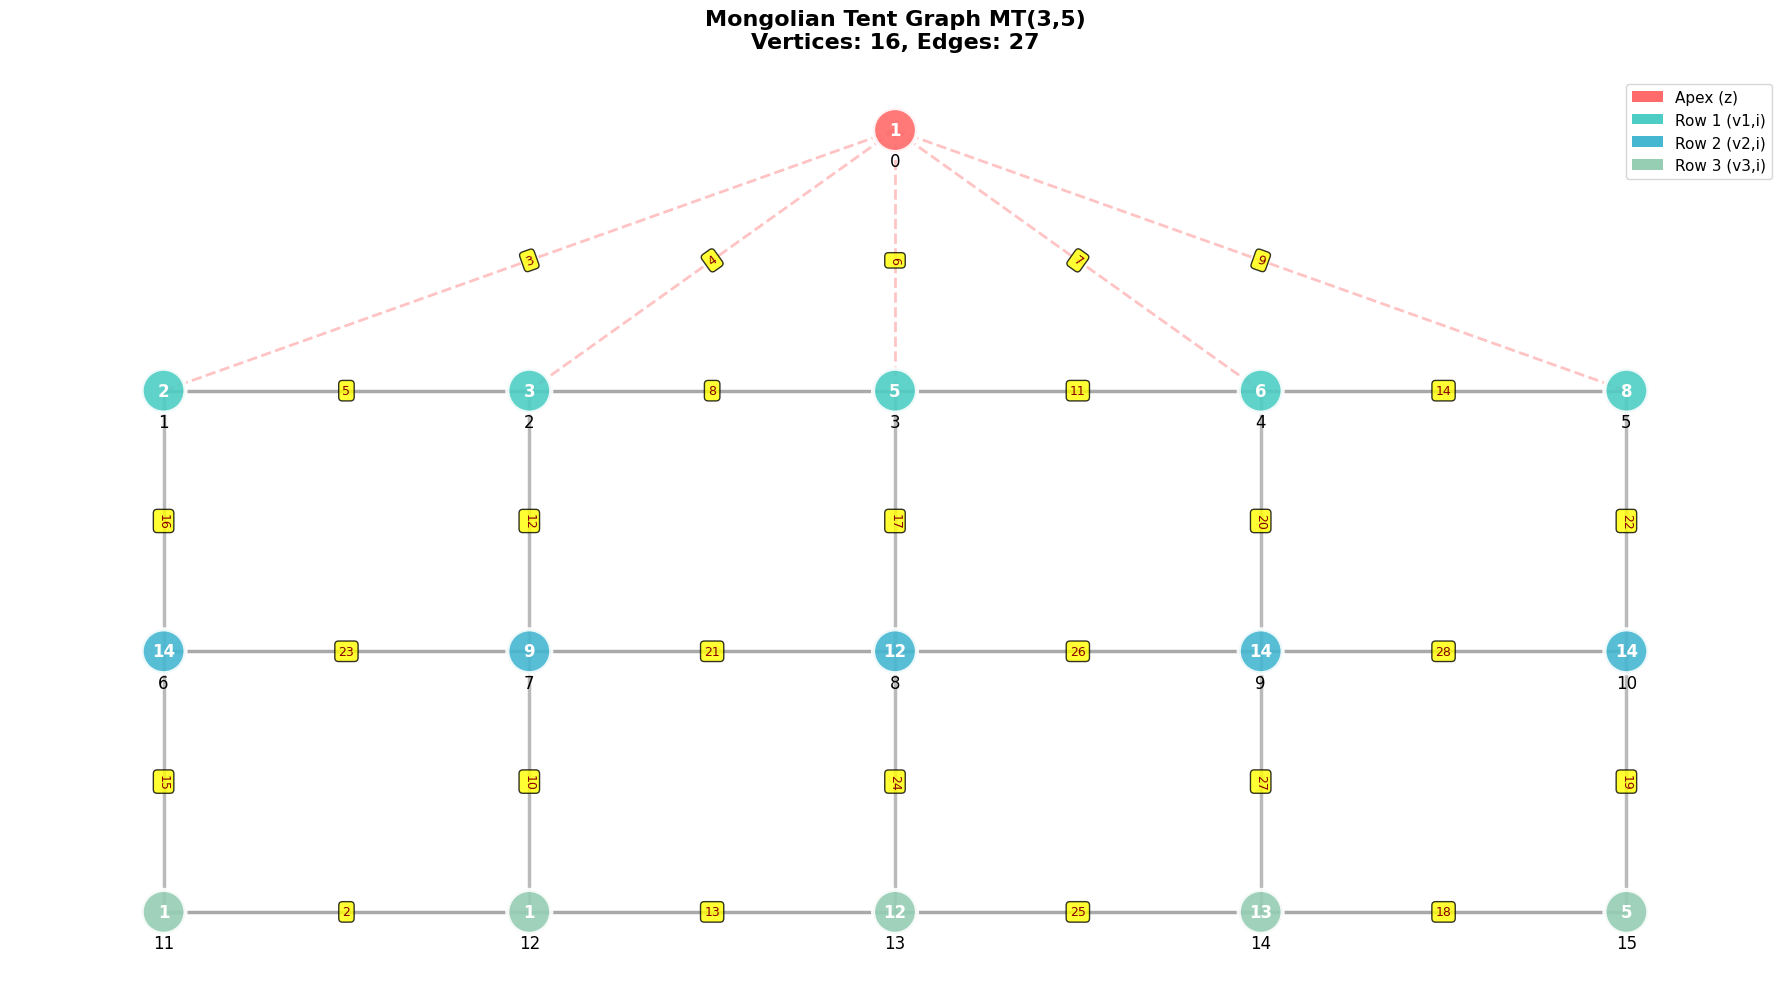

Apex (z): 1
Row 1: [2, 3, 5, 6, 8]
Row 2: [14, 9, 12, 14, 14]
Row 3: [1, 1, 12, 13, 5]
Edge weights (sorted): [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Max vertex label: 14


In [30]:
from typing import List, Dict, Set, Optional
from collections import deque
import time
import matplotlib.pyplot as plt
import networkx as nx
import math


class MongolianTentSolver:
    def __init__(self, n: int):
        # Give an error if n is not between 5 and 50 since these are the bounds from the project
        if not 5 <= n <= 50:
            raise ValueError("n must be between 5 and 50")

        # Setting variables in the class based on the user input
        self.n = n
        self.num_vertices = 3 * n + 1

        # Building adjacency list
        self.adj_list: Dict[int, List[int]] = {i: [] for i in range(self.num_vertices)}
        self.edges = []

        # This is creating the structure that the verticies will be stored in
        apex = 0
        row1 = list(range(1, n + 1))
        row2 = list(range(n + 1, 2 * n + 1))
        row3 = list(range(2 * n + 1, 3 * n + 1))

        # This function is responsible for adding the edges
        def add_edge(u, v):
            # This takes the smaller vertex, larger vertex so that we dont store duplicates
            edge = (min(u, v), max(u, v))
            # Checks if the edge is in the edge list, if not then it adds it
            if edge not in self.edges:
                self.edges.append(edge)
                self.adj_list[u].append(v)
                self.adj_list[v].append(u)

        # Connect apex to first row
        for v in row1:
            add_edge(apex, v)

        # Connect rows horizontally
        for i in range(len(row1) - 1):
            add_edge(row1[i], row1[i + 1])
        for i in range(len(row2) - 1):
            add_edge(row2[i], row2[i + 1])
        for i in range(len(row3) - 1):
            add_edge(row3[i], row3[i + 1])

        # Connect rows vertically
        for i in range(n):
            add_edge(row1[i], row2[i])
            add_edge(row2[i], row3[i])

        # Variable to keep track of how many edges there are (used for theoretical best predictions)
        self.num_edges = len(self.edges)

        # This is the relaxed solution
        self.max_search_max_label = self.num_edges

        # Vars to keep track of labels and edge weights used
        self.labels = {}
        self.used_edge_weights: Set[int] = set()
        self.solution_found = False

    # This will traverse the graph in BFS order (starting at root) and then return those verticies in BFS order
    def get_bfs_order(self) -> List[int]:
        visited = set()
        order = []
        queue = deque([0])
        visited.add(0)
        while queue:
            vertex = queue.popleft()
            order.append(vertex)
            for neighbor in self.adj_list[vertex]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(neighbor)
        return order

    # This will take in two verticies and then compute the edge weight
    def get_edge_weight(self, u: int, v: int) -> int:
        return self.labels.get(u, 0) + self.labels.get(v, 0)

    # Finds all possible labels we can assign to a vertex
    def get_valid_labels(self, vertex: int, max_label: int) -> List[int]:
        # Initializes a list to store all valid labels for the current vertex
        valid = []

        # Goes through each possible label from 1 to the max_label
        for label in range(1, max_label + 1):

            # Assumes edge weight is valid until disproved
            is_valid = True
            temp_weights = set()

            # Check each neighbor in the adj list for curr vertex
            for neighbor in self.adj_list[vertex]:

                # Checks only neighbors that already have labels (dont waste time if no label)
                if neighbor in self.labels:

                    # calculate edge weight based on vertex labels
                    weight = label + self.labels[neighbor]

                    # If the edge weight is outside of acceptable range, discard
                    if weight < self.min_edge_weight or weight > self.max_edge_weight:
                        is_valid = False
                        break

                    # If edge weight is already used, discard
                    if weight in self.used_edge_weights or weight in temp_weights:
                        is_valid = False
                        break

                    # temp store the new weight in case it turns out to be valid
                    temp_weights.add(weight)
            # If the weight is valid then add it to the list
            if is_valid:
                valid.append(label)
        return valid

    # This is the function responsible for backtracking
    def backtrack(self, order: List[int], index: int, max_label: int, start_time: float, time_limit: float) -> bool:
        # Check global time limit (enforce 30 second timeout because we dont want to wait forever)
        if time.time() - start_time > time_limit:
            return False

        # Checks if all of the verticies are labeled and have unique edge weights
        if index == len(order):
            if len(self.used_edge_weights) == self.num_edges:
                self.solution_found = True
                return True
            return False

        # Get the vertex to label, and find all of its possible label values
        vertex = order[index]
        valid_labels = self.get_valid_labels(vertex, max_label)
        # By sorting the possible labels in order, it uses a greedy approach by testing smaller values first
        valid_labels.sort()

        # For each of the possible valid labels
        for label in valid_labels:

            # Try the first possible valid label
            self.labels[vertex] = label
            new_weights = set()

            # Calculates all new edge weights that are created by labeling this new vertex
            for neighbor in self.adj_list[vertex]:

                # Checks if neighbor has a label, if so, calculate new edge weight
                if neighbor in self.labels and neighbor != vertex:
                    new_weights.add(self.get_edge_weight(vertex, neighbor))
            old_used = self.used_edge_weights.copy()
            self.used_edge_weights.update(new_weights)

            # Recursively call backtracking function
            if self.backtrack(order, index + 1, max_label, start_time, time_limit):
                return True

            # If no solution is found with the new label, revert back to old label
            self.used_edge_weights = old_used
            del self.labels[vertex]

        # If all valid labels fail, then return false
        return False

    # Tries to solve using the upper bound defined, will iteratively try tighter bounds
    def solve_with_bounds(self, max_edge_weight: int, max_vertex_label: int, start_time: float, time_limit: float) -> Optional[Dict[int, int]]:
        # 2 is the theoretical best edge weight coming from 1 and 1 verticies
        self.min_edge_weight = 2
        self.max_edge_weight = max_edge_weight
        self.max_search_max_label = max_vertex_label
        self.labels = {}
        self.used_edge_weights = set()
        self.solution_found = False

        order = self.get_bfs_order()
        if self.backtrack(order, 0, max_vertex_label, start_time, time_limit):
            return self.labels.copy()
        return None

    # This will try loose bounds at first, then try smaller (tighter) bounds
    def optimize_solution_iterative(self, time_limit=30) -> Optional[Dict[int, int]]:
        start_time = time.time()

        # How much to increase the bounds (at least 5)
        relax_factor = self.n

        # Sets the current max edge and label to try
        current_max_edge = self.num_edges + relax_factor
        current_max_label = self.max_search_max_label + relax_factor
        best_solution = None

        # Stop if total time exceeds time limit and keep looping otherwise
        while True:
            if time.time() - start_time > time_limit:
                print("Time limit reached.")
                break

            # try to solve given the current bounds (very relaxed at first)
            solution = self.solve_with_bounds(current_max_edge, current_max_label, start_time, time_limit)

            # If it finds a solution, that becomes the best solution and then prints curr best to console
            if solution:
                best_solution = solution
                best_max_label = max(solution.values())
                best_max_edge = max([self.get_edge_weight(u, v) for u, v in self.edges])
                print(f"Found solution: max vertex label={best_max_label}, max edge weight={best_max_edge}")

                # Stop if best K value is reached
                best_K = math.ceil((self.num_edges + 1) / 2)
                if best_max_label <= best_K:
                    print("Best K reached.")
                    break

                # tighten bounds for next iteration by taking best from prev solution and decrement by 1
                current_max_label = best_max_label - 1
                current_max_edge = best_max_edge - 1
            else:
                break  # no better solution

        # If we have a best solution, show it
        if best_solution:
            self.labels = best_solution
            self.solution_found = True
        return best_solution

    # Gives a visualization of the completed graph, AI generated but prof said its okay since its visuals only
    def visualize(self, figsize=(16, 10), show_edge_labels=True):
        if not self.solution_found:
            print("No solution to visualize. Please solve first.")
            return

        G = nx.Graph()
        for v in range(self.num_vertices):
            G.add_node(v, label=self.labels.get(v, 0))

        edge_labels_dict = {}
        edge_weights = []
        for u, v in self.edges:
            weight = self.get_edge_weight(u, v)
            G.add_edge(u, v, weight=weight)
            edge_labels_dict[(u, v)] = weight
            edge_weights.append(weight)

        pos = self._create_grid_layout()
        fig, ax = plt.subplots(figsize=figsize)

        apex = 0
        row1 = list(range(1, self.n + 1))
        row2 = list(range(self.n + 1, 2 * self.n + 1))
        row3 = list(range(2 * self.n + 1, 3 * self.n + 1))

        node_colors = []
        for v in range(self.num_vertices):
            if v == apex:
                node_colors.append('#ff6b6b')
            elif v in row1:
                node_colors.append('#4ecdc4')
            elif v in row2:
                node_colors.append('#45b7d1')
            else:
                node_colors.append('#96ceb4')

        horizontal_edges = []
        vertical_edges = []
        apex_edges = []

        for u, v in G.edges():
            if u == 0 or v == 0:
                apex_edges.append((u, v))
            elif abs(u - v) == 1 or abs(u - v) == self.n - 1:
                horizontal_edges.append((u, v))
            else:
                vertical_edges.append((u, v))

        nx.draw_networkx_edges(G, pos, edgelist=apex_edges,
                               alpha=0.4, width=2, edge_color='#ff6b6b', style='dashed')
        nx.draw_networkx_edges(G, pos, edgelist=horizontal_edges,
                               alpha=0.5, width=2.5, edge_color='#555')
        nx.draw_networkx_edges(G, pos, edgelist=vertical_edges,
                               alpha=0.5, width=2.5, edge_color='#777')

        nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                               node_size=1000, alpha=0.9,
                               edgecolors='white', linewidths=3)

        vertex_labels = {v: f"{self.labels.get(v, 0)}" for v in range(self.num_vertices)}
        nx.draw_networkx_labels(G, pos, vertex_labels, font_size=12,
                                font_weight='bold', font_color='white')

        index_labels = {v: str(v) for v in range(self.num_vertices)}
        nx.draw_networkx_labels(
            G,
            {v: (pos[v][0], pos[v][1] - 0.3) for v in pos},
            index_labels,
            font_size=12,
            font_color='black'
        )

        if show_edge_labels:
            nx.draw_networkx_edge_labels(G, pos, edge_labels_dict, font_size=9,
                                         font_color='darkred',
                                         bbox=dict(boxstyle='round,pad=0.3',
                                         facecolor='yellow', alpha=0.8))

        ax.set_title(f'Mongolian Tent Graph MT(3,{self.n})\n'
                       f'Vertices: {self.num_vertices}, Edges: {self.num_edges}',
                       fontsize=16, fontweight='bold', pad=20)

        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#ff6b6b', label='Apex (z)'),
            Patch(facecolor='#4ecdc4', label='Row 1 (v1,i)'),
            Patch(facecolor='#45b7d1', label='Row 2 (v2,i)'),
            Patch(facecolor='#96ceb4', label='Row 3 (v3,i)')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

        ax.axis('off')
        plt.tight_layout()
        plt.show()

        print(f"Apex (z): {self.labels.get(0, 0)}")
        print(f"Row 1: {[self.labels.get(i, 0) for i in range(1, self.n + 1)]}")
        print(f"Row 2: {[self.labels.get(i, 0) for i in range(self.n + 1, 2*self.n + 1)]}")
        print(f"Row 3: {[self.labels.get(i, 0) for i in range(2*self.n + 1, 3*self.n + 1)]}")
        print(f"Edge weights (sorted): {sorted(edge_weights)}")
        print(f"Max vertex label: {max(self.labels.values())}")

    def _create_grid_layout(self) -> Dict[int, tuple]:
        pos = {}
        horizontal_spacing = 2.0
        vertical_spacing = 2.5
        width = (self.n - 1) * horizontal_spacing
        center_x = width / 2
        pos[0] = (center_x, 3 * vertical_spacing)
        for i in range(self.n):
            pos[1 + i] = (i * horizontal_spacing, 2 * vertical_spacing)
            pos[self.n + 1 + i] = (i * horizontal_spacing, 1 * vertical_spacing)
            pos[2 * self.n + 1 + i] = (i * horizontal_spacing, 0)
        return pos

def main():
    # Put the n value to try (between 5 and 50)
    n = 5

    # init a MongolianTentSolver class with n
    solver = MongolianTentSolver(n)

    # Compute and print theoretical best K and max edge weight
    print(f"Theoretical best max vertex label (K): {math.ceil((solver.num_edges + 1) / 2)}")
    print(f"Theoretical best max edge weight: {solver.num_edges + 1}\n")

    # Start with loose bounds, then tighten when solution is found
    solution = solver.optimize_solution_iterative()

    # If we get a solution, show it
    if solution:
        solver.visualize(figsize=(18, 10), show_edge_labels=True)
    else:
        print("No valid solution found")

if __name__ == "__main__":
    main()
